In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.interpolate import CubicSpline

from lammps_implicit_der import LammpsImplicitDer, SNAP
from lammps_implicit_der.tools import mpi_print, initialize_mpi, TimingGroup, plot_tools
from lammps_implicit_der.systems import BCC, BCC_BINARY

# Setup Tungsten bcc system

In [2]:
class LammpsSim(LammpsImplicitDer):
    def __init__(self,
                 mass = 184.0,
                 ncell_x = 3,
                 alat = 3.262,
                 data_path='../../lammps_implicit_der/data_files/',
                 snapcoeff_filename = 'W_REF.snapcoeff',
                 #snapcoeff_filename = 'W.snapcoeff',
                 *args, **kwargs):

        super().__init__(*args, **kwargs)

        # Load the SNAP potential
        self.pot = SNAP.from_files(snapcoeff_filename, data_path=data_path)

        if len(self.pot.elem_list) > 1:
            raise RuntimeError('system must be a single element')
        self.element = self.pot.elem_list[0]
        self.Theta = self.pot.Theta_dict[self.element]['Theta']

        self.ncell_x = ncell_x

        # Set the system
        self.lmp_commands_string(f"""
        clear

        atom_modify map array sort 0 0.0
        boundary p p p

        # Initialize simulation
        units metal
        lattice bcc {alat} origin 0.01 0.01 0.01

        # create a block of atoms
        region C block 0 {ncell_x} 0 {ncell_x} 0 {ncell_x} units lattice
        create_box 1 C
        create_atoms 1 region C

        mass * {mass}
        """)

        self.run_init()

    def get_E(self):
        """
            Return energy D(X+dX)@(T+dT)
        """

        D = self.dU_dTheta
        T = self.Theta
        E = D @ T

        return E

    def get_pressure_from_virial(self):
        """
            Return pressure from virial as the trace of the virial tensor contracted with the potential parameters.
        """

        if self.Theta is None or self.virial is None:
            raise RuntimeError('Theta and virial must be set to calculate pressure')

        pressure_tensor = np.dot(np.sum(self.virial, axis=0), self.Theta)
        self.pressure = np.sum(pressure_tensor[:3]) / 3.0

ncell_x = 2
#alat = 3.262
#alat = 3.185
alat = 3.18427
W_system = LammpsSim(ncell_x=ncell_x, alat=alat, logname='log.W')


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log log.W

Setting SNAP potential

                  SNAP coefficients for: W
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Minimization finished in 1 steps
Initial fmax: 1.021e-14, final fmax: 1.177e-14
Initial fnorm: 3.953e-14, final fnorm: 4.305e-14
Number of atoms: 16, largest force value: 1.177e-14, force norm: 4.305e-14


## Basic parameters

In [3]:
delta = 10.0
sample = 1
data_path='../../lammps_implicit_der/data_files/'
# system_tmp is created only to save the SNAP potential files
system_tmp = LammpsSim(data_path=data_path, snapcoeff_filename='W_REF.snapcoeff', snapparam_filename='W_REF.snapparam',
                            ncell_x=ncell_x, alat=alat, logname='tmp.log', minimize=False, verbose=False)

system_tmp.scatter_coord()
system_tmp.compute_D_dD()
system_tmp.gather_D_dD()
energy_thermo_pe0 = system_tmp.energy
energy_desc0 = system_tmp.dU_dTheta @ system_tmp.Theta #system_tmp.pot.Theta_dict['W']['Theta']

print('*'*80)
print(f'{energy_thermo_pe0=}, {energy_desc0=}')
print('*'*80)

********************************************************************************
energy_thermo_pe0=-89.06088966749098, energy_desc0=-89.06088966749101
********************************************************************************


In [4]:
print(W_system.pot.elem_list)
print(W_system.pot.Theta_dict.keys())
print(W_system.pot.snapparam_dict)
#W_system.implicit_derivative(method='energy', alpha=1e-4, min_style='cg')

['W']
dict_keys(['W', 'radii', 'weights'])
{'rcutfac': 5.0, 'twojmax': 8, 'rfac0': 0.99363, 'rmin0': 0, 'bzeroflag': 1, 'quadraticflag': 0, 'bnormflag': 0}


In [5]:
W_system.minimize_energy()

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Minimization finished in 1 steps
Initial fmax: 1.177e-14, final fmax: 1.110e-14
Initial fnorm: 4.305e-14, final fnorm: 3.652e-14


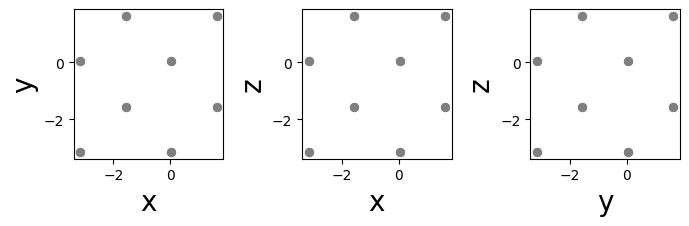

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(7, 4))
plot_tools.plot_coords(axes, W_system.X_coord.reshape(-1, 3), c='gray', s=32)
plt.tight_layout()

In [7]:
W_system.scatter_coord()
W_system.gather_D_dD()
#dX_dTheta = W_system.implicit_derivative(method='inverse')

In [8]:
W_system.compute_virial()
W_system.gather_virial()
Theta0 = W_system.Theta.copy()

virial = W_system.virial
print(f'{virial.shape=}')

virial_sum_atoms = np.sum(virial, axis=0)
print(f'{virial_sum_atoms.shape=}')

pressure_tensor = np.dot(virial_sum_atoms, Theta0)
print(f'{pressure_tensor}')

virial.shape=(16, 6, 55)
virial_sum_atoms.shape=(6, 55)
[-2.90898916e-03 -2.90898916e-03 -2.90898916e-03 -4.17686035e-15
  1.26848172e-14 -1.15877543e-14]


# Energy-volume curve for pure lattice

In [9]:
def compute_energy_volume(system, epsilon_array):

    energy_array = np.zeros_like(epsilon_array)
    energy_array2 = np.zeros_like(epsilon_array)
    volume_array = np.zeros_like(epsilon_array)

    virial_array = np.zeros((epsilon_array.shape[0], 6, system.Ndesc))
    pressure_array = np.zeros_like(epsilon_array)

    system.scatter_coord()
    system.gather_D_dD()

    system.compute_virial()

    system.get_cell()
    initial_cell = system.cell

    for i, epsilon in enumerate(epsilon_array):

        #M = np.diag([epsilon, epsilon, -2.0 * epsilon])
        M = np.diag([epsilon, epsilon, epsilon])

        cell = np.dot(initial_cell, (np.eye(3) + M))

        system.change_box(cell)

        volume = np.linalg.det(cell)
        volume_array[i] = volume

        system.gather_D_dD()
        energy = system.get_E()

        # extract_compute("thermo_pe")
        energy2 = system.energy

        energy_array[i] = energy
        energy_array2[i] = energy2

        system.gather_virial()
        virial_array[i, :, :] = np.sum(system.virial, axis=0)

        system.get_pressure_from_virial()
        pressure_array[i] = system.pressure


    # Reapply the original cell
    system.change_box(initial_cell)

    energy_array /= system.ncell_x**3
    energy_array2 /= system.ncell_x**3

    energy_array -= energy_array.min()
    energy_array2 -= energy_array2.min()

    return energy_array, energy_array2, volume_array, virial_array, pressure_array

Error in compute_virial: ERROR: Reuse of compute ID 'virial' (src/modify.cpp:1240)
Minimum energy at strain: 0.000%; volume: 258.297 A^3; alat: 3.18427 A; pressure: -0.0029


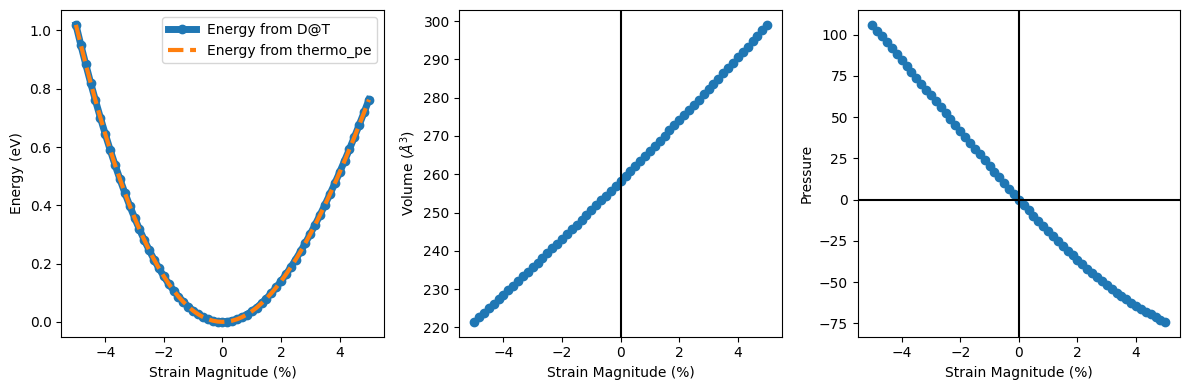

In [10]:
epsilon_array = np.linspace(-0.05, 0.05, 61)
#epsilon_array = np.linspace(-0.0005, 0.0005, 501)

energy_array, energy_array2, volume_array, virial_array, pressure_array = compute_energy_volume(W_system, epsilon_array)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(100.0 * epsilon_array, energy_array, ls='-', marker='o', lw=5, label='Energy from D@T')
axes[0].plot(100.0 * epsilon_array, energy_array2, ls='--', marker='', lw=3, label='Energy from thermo_pe')
axes[0].set_xlabel('Strain Magnitude (%)')
axes[0].set_ylabel('Energy (eV)')
axes[0].legend()

idx_min = np.argmin(energy_array)
strain_min = epsilon_array[idx_min]
vol_min = volume_array[idx_min]
pressure_min = pressure_array[idx_min]
print(f"Minimum energy at strain: {strain_min:.3%}; volume: {vol_min:.3f} A^3; alat: {vol_min**(1/3.0)/ncell_x:.5f} A;"
      f" pressure: {pressure_min:.4f}")

axes[1].plot(100.0 * epsilon_array, volume_array, ls='-', marker='o')
axes[1].set_xlabel('Strain Magnitude (%)')
axes[1].set_ylabel('Volume ($\AA ^3$)')
axes[1].axvline(0.0, color='k', ls='-')

axes[2].plot(100.0 * epsilon_array, pressure_array, ls='-', marker='o')
axes[2].set_xlabel('Strain Magnitude (%)')
axes[2].set_ylabel('Pressure')
axes[2].axhline(0.0, color='k', ls='-')
axes[2].axvline(0.0, color='k', ls='-')

plt.tight_layout()
plt.show()

## Virial components as a function of strain

W_system.virial.shape=(16, 6, 55)
virial_array.shape=(61, 6, 55)
contracted_array.shape=(61, 55)


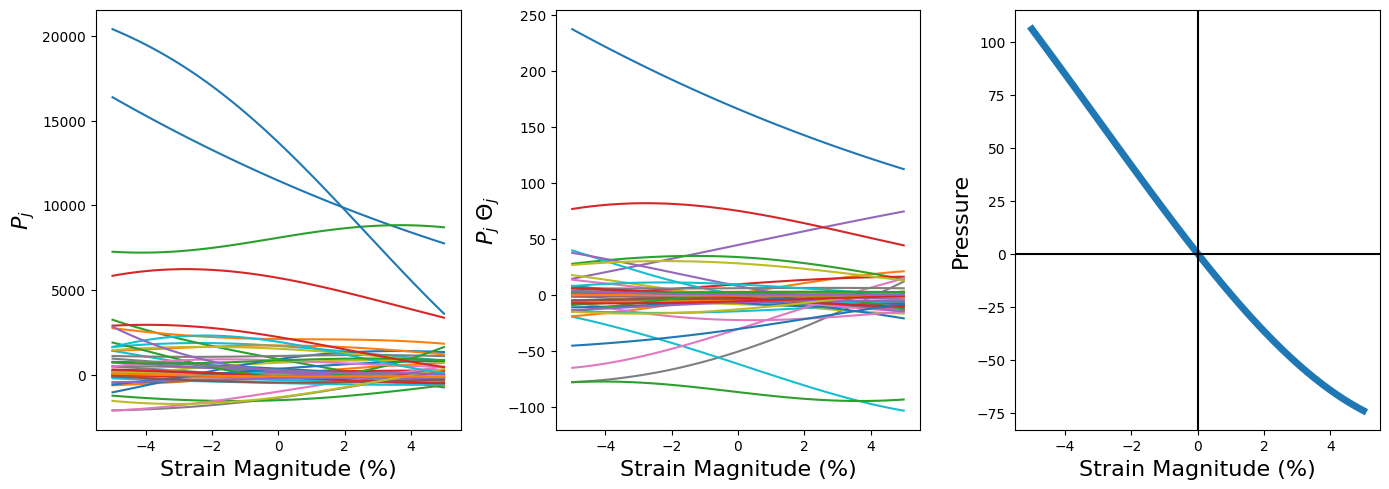

In [11]:
print(f'{W_system.virial.shape=}')
print(f'{virial_array.shape=}')

virial_trace_array = np.sum(virial_array[:, :3, :], axis=1) / 3.0

# e - epsilon, i - virial index, j - descriptor index
contracted_array = np.einsum('ej,j->ej', virial_trace_array[:, :], W_system.Theta[:])
print(f'{contracted_array.shape=}')

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for idesc in range(W_system.Ndesc):
    axes[0].plot(100.0 * epsilon_array, virial_trace_array[:, idesc], label=f'virial {idesc}')
    axes[1].plot(100.0 * epsilon_array, contracted_array[:, idesc], label=f'virial {idesc}')

fsize = 16
axes[0].set_xlabel('Strain Magnitude (%)', fontsize=fsize)
axes[0].set_ylabel('$P_j$', fontsize=fsize)

axes[1].set_xlabel('Strain Magnitude (%)', fontsize=fsize)
axes[1].set_ylabel(r'$P_j \; \Theta_j$', fontsize=fsize)

axes[2].plot(100.0 * epsilon_array, pressure_array, label=f'virial {idesc}', lw=5.0)
axes[2].set_xlabel('Strain Magnitude (%)', fontsize=fsize)
axes[2].set_ylabel('Pressure', fontsize=fsize)
axes[2].axhline(0.0, color='k', ls='-')
axes[2].axvline(0.0, color='k', ls='-')

plt.tight_layout()
plt.show()


## Polynomial interpolation of $P_j$

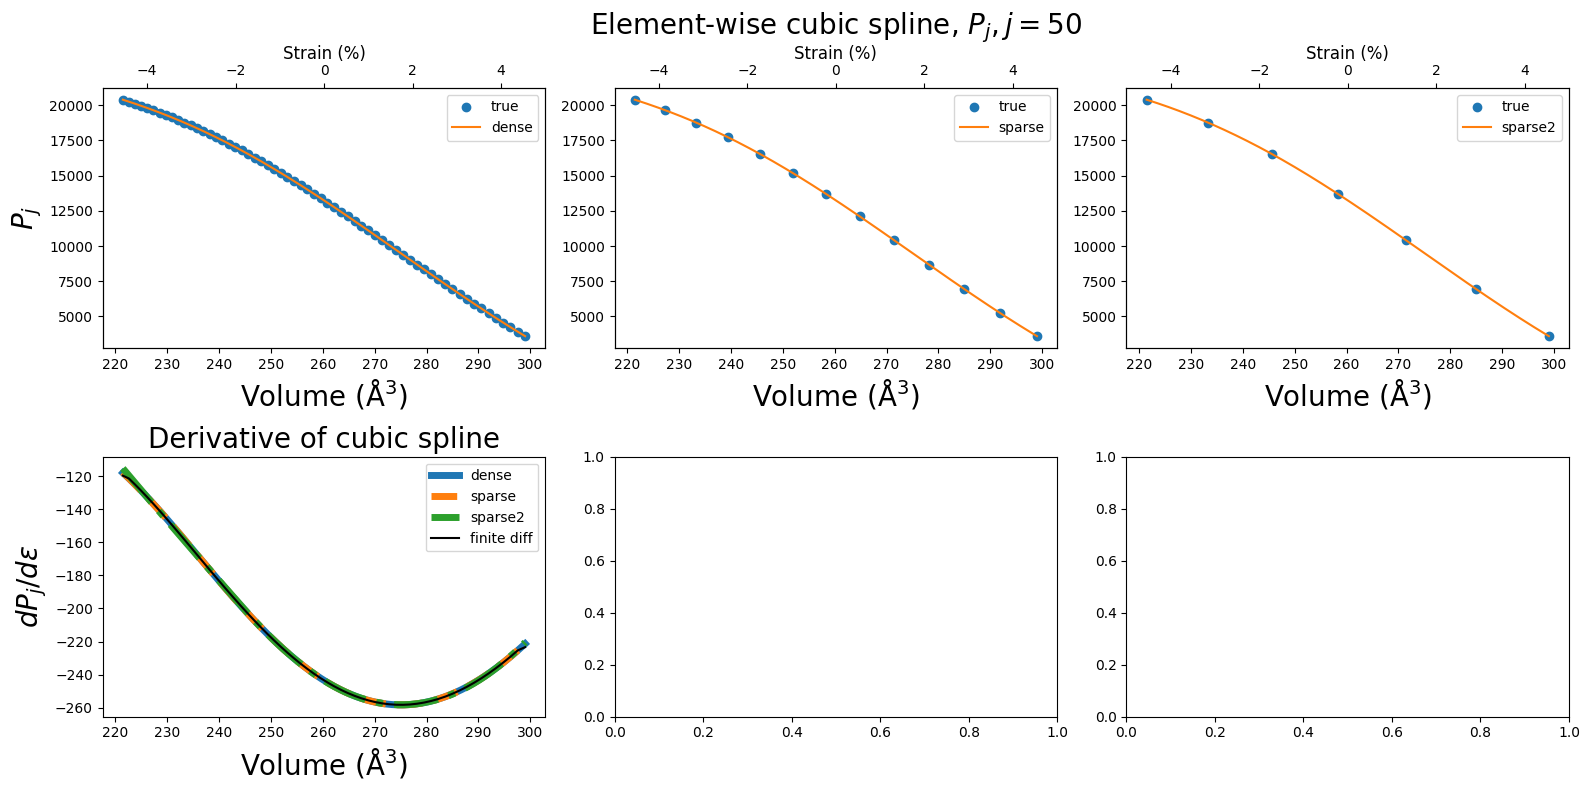

In [12]:
# Polynomial interpolation
#j_index = 10
j_index = 50

spline_list = []

for idesc in range(W_system.Ndesc):
    spline_list.append(CubicSpline(volume_array, virial_trace_array[:, idesc]))

nsparse = 5
spline_list_sparse = []
for idesc in range(W_system.Ndesc):
    spline_list_sparse.append(CubicSpline(volume_array[::nsparse], virial_trace_array[::nsparse, idesc]))

nsparse2 = 10
spline_list_sparse2 = []
for idesc in range(W_system.Ndesc):
    spline_list_sparse2.append(CubicSpline(volume_array[::nsparse2], virial_trace_array[::nsparse2, idesc]))

vol_grid = np.linspace(np.min(volume_array), np.max(volume_array), 1001)

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes[0,0].plot(volume_array, virial_trace_array[:, j_index], marker='o', ls='', label='true')
axes[0,0].plot(vol_grid, spline_list[j_index](vol_grid), label='dense', ls='-')

axes[0,1].plot(volume_array[::nsparse], virial_trace_array[::nsparse, j_index], marker='o', ls='', label='true')
axes[0,1].plot(vol_grid, spline_list_sparse[j_index](vol_grid), label='sparse', ls='-')

axes[0,2].plot(volume_array[::nsparse2], virial_trace_array[::nsparse2, j_index], marker='o', ls='', label='true')
axes[0,2].plot(vol_grid, spline_list_sparse2[j_index](vol_grid), label='sparse2', ls='-')


legend_list =['dense', 'sparse', 'sparse2']
ls_list = ['-', '--', '-.']
fsize = 20
for i, slist in enumerate([spline_list, spline_list_sparse, spline_list_sparse2]):
    axes[1,0].plot(vol_grid, slist[j_index](vol_grid, nu=1), label=legend_list[i], ls=ls_list[i], lw=5.0)

# finite difference derivative
der_finite_diff = np.gradient(virial_trace_array[:, j_index], volume_array)
axes[1,0].plot(volume_array, der_finite_diff, marker='', ls='-', label='finite diff', color='black')

axes[1, 0].legend()
axes[1,0].set_xlabel('Volume ($\mathrm{\AA}^3$)', fontsize=fsize)
axes[1, 0].set_ylabel('$dP_j/d\epsilon$', fontsize=fsize)

axes[0,0].set_ylabel('$P_j$', fontsize=fsize)
for i in range(3):
    axes[0,i].set_xlabel('Volume ($\mathrm{\AA}^3$)', fontsize=fsize)
    #axes[0,i].set_ylabel('$P_j$', fontsize=fsize)
    axes[0,i].legend()

    # set second x axis as strain
    ax2 = axes[0,i].twiny()
    ax2.set_xlim(100.0 * epsilon_array[0], 100.0 * epsilon_array[-1])
    ax2.set_xlabel('Strain (%)', fontsize=12)

axes[1,0].set_title('Derivative of cubic spline', fontsize=20)

axes[0,1].set_title(f'Element-wise cubic spline, $P_j, j=${j_index}', fontsize=20)
plt.tight_layout()
plt.show()



# Perturb the potential parameters parameters and create new perturbed instances of Lammps class

In [13]:
# Load the Theta ens pickle file
path = '../../lammps_implicit_der/data_files/'
filename = 'Theta_ens.pkl'
with open(os.path.join(path, filename), 'rb') as file:
    Theta_ens = pickle.load(file)

def create_perturbed_system(delta, sample=1, alat=3.185, logname='W_perturb.log', perturb_type='ens', index=10, fix_box_relax=False):

    W_tmp = LammpsSim(ncell_x=ncell_x, alat=alat, logname='W_tmp.log', minimize=False, verbose=False)

    if perturb_type == 'ens':
        Theta_perturb = Theta_ens['Theta_mean'] + delta * (Theta_ens['Theta_ens_list'][sample] - Theta_ens['Theta_mean'])
    elif perturb_type == 'index':
        Theta_perturb = W_tmp.pot.Theta_dict['W']['Theta'].copy()
        Theta_perturb[index] += delta


    # Set the perturbed parameters
    W_tmp.pot.Theta_dict['W']['Theta'] = Theta_perturb
    W_tmp.pot.to_files(path='.', overwrite=True, snapcoeff_filename='W_perturb.snapcoeff', snapparam_filename='W_perturb.snapparam', verbose=False)

    W_perturb = LammpsSim(ncell_x=ncell_x, alat=alat, logname=logname, minimize=False, verbose=False,
                        snapcoeff_filename='W_perturb.snapcoeff', snapparam_filename='W_perturb.snapparam', fix_box_relax=fix_box_relax,
                        data_path='.')

    return W_perturb

Minimum energy at strain: -0.600%; volume: 258.297 A^3; alat: 3.1652 A
vol_min_pert=253.676, vol_init_pert=258.297, V1-V0 = -4.622


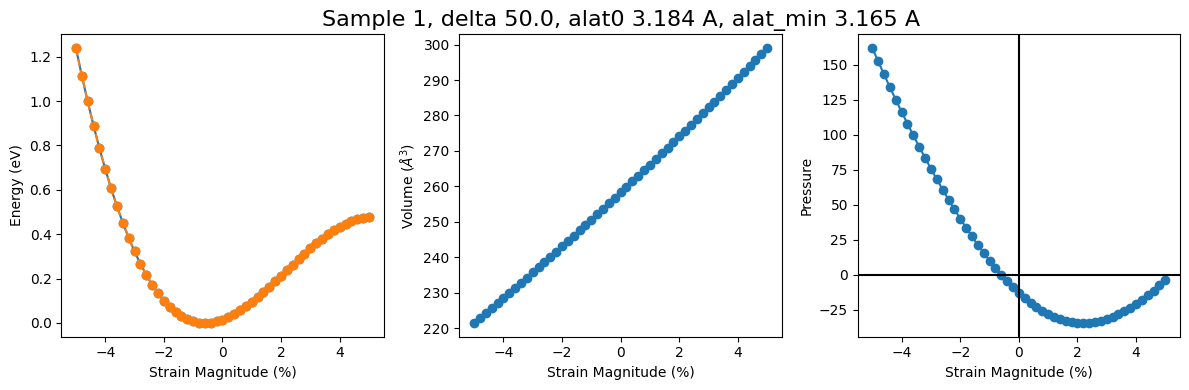

In [14]:
epsilon_array_pert = np.linspace(-0.05, 0.05, 51)

alat2 = alat
sample = 1
delta = 50.0
W_perturb = create_perturbed_system(delta=delta, sample=sample, alat=alat, perturb_type='ens', fix_box_relax=False)
#W_perturb = create_perturbed_system(delta=0.5, alat=alat2, perturb_type='index', index=10, fix_box_relax=False)

energy_array_pert, energy_array2_pert, volume_array_pert, virial_array_pert, pressure_array_pert = \
    compute_energy_volume(W_perturb, epsilon_array_pert)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(100.0 * epsilon_array_pert, energy_array_pert, ls='-', marker='o')
axes[0].plot(100.0 * epsilon_array_pert, energy_array2_pert, ls='--', marker='o')
axes[0].set_xlabel('Strain Magnitude (%)')
axes[0].set_ylabel('Energy (eV)')

strain_min_pert = epsilon_array_pert[np.argmin(energy_array_pert)]
vol_min_pert = volume_array_pert[np.argmin(energy_array_pert)]

# Volume at zero strain
vol_init_pert = volume_array_pert[np.argmin(np.abs(epsilon_array_pert))]
alat_min = vol_min_pert**(1/3.0) / ncell_x

print(f"Minimum energy at strain: {strain_min_pert:.3%}; volume: {vol_min:.3f} A^3; alat: {alat_min:.4f} A")

print(f'{vol_min_pert=:.3f}, {vol_init_pert=:.3f}, V1-V0 = {vol_min_pert - vol_init_pert:.3f}')

axes[1].plot(100.0 * epsilon_array_pert, volume_array_pert, ls='-', marker='o')
axes[1].set_xlabel('Strain Magnitude (%)')
axes[1].set_ylabel('Volume ($\AA ^3$)')

axes[2].plot(100.0 * epsilon_array_pert, pressure_array_pert, ls='-', marker='o')
axes[2].set_xlabel('Strain Magnitude (%)')
axes[2].set_ylabel('Pressure')
axes[2].axhline(0.0, color='k', ls='-')
axes[2].axvline(0.0, color='k', ls='-')

fsize=16
axes[1].set_title(f'Sample {sample}, delta {delta:.1f}, alat0 {alat2:.3f} A, alat_min {alat_min:.3f} A', fontsize=fsize)

plt.tight_layout()
plt.show()

# Volume change with `fix box/relax`

In [15]:
alat_perturb2 = alat
sample = 1
delta = 50.0
W_perturb2 = create_perturbed_system(delta=delta, sample=sample, alat=alat_perturb2, logname='W_perturb2.log')

ftol = 1e-8
algo = 'cg'
maxiter = 1000
maxeval = 1000

W_perturb2.get_cell()
cell_perturb2 = W_perturb2.cell
volume_initial = np.linalg.det(cell_perturb2)
alat_initial = volume_initial**(1/3.0)/ncell_x

print('*'*80)
print(f'{volume_initial = :.3f} A^3; {alat_initial = :.3f} A')
print('*'*80)

W_perturb2.lmp.commands_string(f"""
    fix 1 all box/relax iso 0.0 vmax 0.1
    minimize 0 {ftol} {maxiter} {maxeval}
""")

W_perturb2.get_cell()

volume_final = np.linalg.det(W_perturb2.cell)
alat_final = volume_final**(1/3.0)/ncell_x

print('*'*80)
print(f'{volume_final = :.3f} A^3; V1-V0 {volume_final-volume_initial:.3f}; {alat_final = :.4f} A')
print('*'*80)



********************************************************************************
volume_initial = 258.297 A^3; alat_initial = 3.184 A
********************************************************************************
********************************************************************************
volume_final = 547.859 A^3; V1-V0 289.562; alat_final = 4.0913 A
********************************************************************************


## Predict the volume change:
$$ \Delta V = - \frac{P_j \Delta \Theta_j}{P'_j\Theta_j}, \quad \Delta \Theta_j = \Theta_j^{(1)}-\Theta_j^{(0)}, \quad P'_j = \frac{\partial P_j}{\partial V}\Bigg|_{\Theta = \Theta^{(0)}, V=V_0} $$ 

P_j Theta_j: -0.002908989163378173
[-2.90898916e-03 -2.90898916e-03 -2.90898916e-03 -2.47270503e-14
 -1.16857201e-14 -1.56885499e-15]
Predicted volume change: -5.085 A^3
True volume change: -4.622 A^3


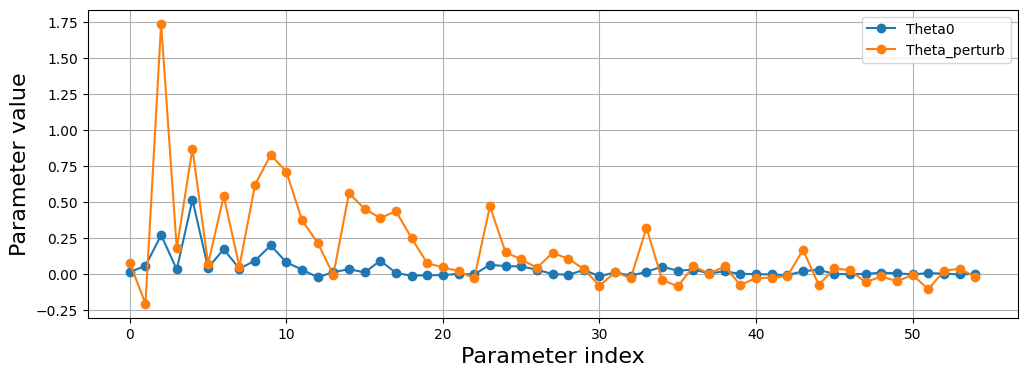

In [16]:
W_system.gather_virial(); W_perturb.gather_virial()

Theta0 = W_system.Theta.copy()
Theta_perturb = W_perturb.Theta.copy()
dTheta = Theta_perturb - Theta0

# virial of the non-perturbed system
# (6, Ndesc)
virial = np.sum(W_system.virial, axis=0)

# (Ndesc)
virial_trace = np.sum(virial[:3, :], axis=0) / 3.0

cell_init = W_system.cell
vol_init = np.linalg.det(cell_init)

# sanity checks
print(f'P_j Theta_j: {np.dot(virial_trace, Theta0)}')

pressure_tensor = np.dot(np.sum(W_system.virial, axis=0), W_system.Theta)
print(pressure_tensor)

# derivative around initial volume point
virial_der = np.array([spline_list[i](vol_init, nu=1) for i in range(W_system.Ndesc)])

numerator = np.dot(virial_trace, dTheta)
denominator = np.dot(virial_der, Theta0)

delta_V = - numerator / denominator
print(f'Predicted volume change: {delta_V:.3f} A^3')
print(f'True volume change: {vol_min_pert - vol_init_pert:.3f} A^3')

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(Theta0, marker='o', label='Theta0')
ax.plot(Theta_perturb, marker='o', label='Theta_perturb')

ax.set_xlabel('Parameter index', fontsize=16)
ax.set_ylabel('Parameter value', fontsize=16)
ax.legend()
ax.grid()
plt.show()


In [17]:
def compute_virial_derivative(system, epsilon_array):

    energy_array, energy_array2, volume_array, virial_array, pressure_array = compute_energy_volume(system, epsilon_array)

    spline_list = []
    for idesc in range(system.Ndesc):
        spline_list.append(CubicSpline(volume_array, virial_trace_array[:, idesc]))

    vol_init = np.linalg.det(system.cell)
    # Derivative around initial volume point
    virial_der0 = np.array([spline_list[i](vol_init, nu=1) for i in range(system.Ndesc)])

    return virial_der0, spline_list, energy_array, volume_array


def predict_volume_change(delta, virial_der, sample=10, alat0=3.18427, dX_dTheta=None, verbose=True):

    tloc = TimingGroup('Pred. Vol. Change')
    tloc.add('total', level=2).start()

    with tloc.add('create_systems'):
        system0 = LammpsSim(ncell_x=ncell_x, alat=alat0, logname='W_tmp0.log', minimize=False, verbose=False)
        system1 = create_perturbed_system(delta=delta, alat=alat0, logname='W_tmp1.log', perturb_type='ens', sample=sample, fix_box_relax=False)
        system2 = create_perturbed_system(delta=delta, alat=alat0, logname='W_tmp2.log', perturb_type='ens', sample=sample, fix_box_relax=False)
        system3 = create_perturbed_system(delta=delta, alat=alat0, logname='W_tmp2.log', perturb_type='ens', sample=sample, fix_box_relax=True)

    X_coord0 = system0.X_coord.copy()
    cell1 = system1.cell
    volume_init1 = np.linalg.det(cell1)

    epsilon_array_pert = np.linspace(-0.05, 0.05, 51)

    # True volume change from energy-volume curve
    with tloc.add('energy-volume'):
        energy_array_pert, energy_array2_pert, volume_array_pert, virial_array_pert, pressure_array_pert = \
            compute_energy_volume(system1, epsilon_array_pert)
        vol_min_pert = volume_array_pert[np.argmin(energy_array_pert)]
        delta_V_en_vol = vol_min_pert - volume_init1

    # True volume change from fix box/relax
    with tloc.add('box-relax'):
        ftol = 1e-8; algo = 'cg'; maxiter = 1000; maxeval = 1000
        volume_init2 = np.linalg.det(system2.cell)
        system2.lmp.commands_string(f"""
            fix 1 all box/relax iso 0.0 vmax 0.1
            minimize 0 {ftol} {maxiter} {maxeval}
            run 0
        """)
        system2.get_cell()
        delta_V_box_rel = np.linalg.det(system2.cell) - volume_init2

    # Predicted volume change from virial
    with tloc.add('predicted'):
        Theta0 = system0.Theta.copy()
        Theta1 = system1.Theta.copy()
        dTheta = Theta1 - Theta0

        system0.compute_virial()
        system0.gather_virial()

        virial = np.sum(system0.virial, axis=0)
        virial_trace = np.sum(virial[:3, :], axis=0) / 3.0

        delta_V_pred = - np.dot(virial_trace, dTheta) / np.dot(virial_der, Theta0)

    # Predicted from impl. der.
    if dX_dTheta is not None:
        with tloc.add('impl. der.'):
            dX_pred = dTheta @ dX_dTheta
            coord_final = X_coord0 + dX_pred
            #coord_final = system3.minimum_image(coord_init + dX_pred)
            system3._X_coord = coord_final
            system3.scatter_coord()
            system3.get_cell()
            volume_final = np.linalg.det(system3.cell)
            delta_V_impl_der = volume_final - volume_init1
    else:
        delta_V_impl_der = None

    tloc.timings['total'].stop()

    if verbose:
        print(tloc)

    result = {
        'delta_V_en_vol': delta_V_en_vol,
        'delta_V_box_rel': delta_V_box_rel,
        'delta_V_pred': delta_V_pred,
        'delta_V_impl_der': delta_V_impl_der,
        'energy_array': energy_array_pert,
        'pressure_array': pressure_array_pert,
        'tloc': tloc
    }

    return result

In [18]:
system_box_rel = LammpsSim(ncell_x=ncell_x, alat=alat, logname='W_tmp0.log', minimize=False, verbose=False, fix_box_relax=True)
print('Hessian before computing D_dD')
print(np.max(np.abs(system_box_rel.mixed_hessian)))
system_box_rel.compute_D_dD()
system_box_rel.gather_D_dD()
print('Hessian after computing D_dD')
print(np.max(np.abs(system_box_rel.mixed_hessian)))

system_box_rel.lmp.command("fix boxrelax all box/relax iso 0.0 vmax 0.001")
dX_dTheta = system_box_rel.implicit_derivative(method='energy', alpha=1e-4, min_style='cg')
print('Hessian after computing dX_dTheta')
print(np.max(np.abs(system_box_rel.mixed_hessian)))
system_box_rel.compute_D_dD()
system_box_rel.gather_D_dD()
print('Hessian after computing D_dD')
print(np.max(np.abs(system_box_rel.mixed_hessian)))
print(f'{np.max(np.abs(dX_dTheta))=}')

Hessian before computing D_dD
9.663381206337363e-13
Hessian after computing D_dD
9.663381206337363e-13
Hessian after computing dX_dTheta
9.663381206337363e-13
Hessian after computing D_dD
0.008113028417312762
np.max(np.abs(dX_dTheta))=9.407508164621948e-11


In [19]:
print(system_box_rel.impl_der_stats['energy']['f0_norm'])
print(system_box_rel.impl_der_stats['energy']['f1_norm'])

[0.00033854 0.00039275 0.00073    0.00068233 0.00057154 0.00073971
 0.00059035 0.0006233  0.0006083  0.00055413 0.00066005 0.00058379
 0.00073657 0.0005551  0.0006188  0.00059187 0.00081344 0.00046181
 0.00050766 0.0005777  0.00060385 0.00059078 0.00064039 0.00047195
 0.00056857 0.00059273 0.0004943  0.00050234 0.00053033 0.00054571
 0.00076592 0.00065162 0.00061774 0.00055873 0.00052285 0.00057374
 0.00060679 0.00061431 0.00051382 0.00060099 0.00071873 0.00038785
 0.00045557 0.00054335 0.00086009 0.00046508 0.00043087 0.00052338
 0.00061071 0.00040864 0.00039473 0.00057872 0.00056206 0.00037345
 0.00040477]
[4.10357973e-05 7.89925603e-04 4.91987176e-04 1.84239868e-05
 2.22827900e-04 1.30162293e-06 2.39385720e-06 1.43890605e-05
 6.11996639e-04 8.88570345e-04 3.81403988e-06 3.11678723e-06
 1.84086540e-05 6.01587648e-04 5.35133597e-04 5.44899965e-04
 1.23369569e-03 3.91670660e-04 3.85282758e-04 2.06088524e-04
 5.45326817e-05 6.33826406e-04 3.55272543e-06 2.98475830e-05
 5.01805448e-05 4.

In [20]:
print(np.max(np.abs(dX_dTheta)))
print(dX_dTheta.shape)
print(system_box_rel.mixed_hessian)
print(np.max(np.abs(system_box_rel.mixed_hessian)))

system_box_rel.compute_D_dD()
system_box_rel.gather_D_dD()
print(np.max(np.abs(system_box_rel.mixed_hessian)))

9.407508164621948e-11
(55, 48)
[[-1.61778545e-04 -1.77682391e-04 -9.69945501e-05 ...  1.21442338e-03
   1.25409499e-03  1.31966092e-03]
 [-4.11561287e-06 -9.54538915e-06  3.93037844e-06 ...  2.29838623e-04
   2.43531333e-04  2.43352267e-04]
 [-4.40259711e-07 -2.02880168e-07  1.31796393e-06 ... -2.76931453e-06
  -3.21112708e-06 -5.76537007e-07]
 ...
 [-1.84856725e-04 -2.25378230e-04 -1.90448308e-04 ...  3.91540650e-04
   3.97922682e-04  3.81287085e-04]
 [-1.98872408e-04 -2.01512545e-04 -1.29490896e-04 ...  1.15793369e-03
   1.11406201e-03  1.01780648e-03]
 [ 1.58110521e-04  2.01358541e-04  3.76580896e-04 ...  2.53306985e-03
   2.46942608e-03  2.38153730e-03]]
0.008113028417312762
0.008113028417312762


In [21]:

#delta_array = np.linspace(-100.0, 100.0, 21)
delta_array = np.linspace(-50.0, 50.0, 5)
dV_en_vol_array = np.zeros_like(delta_array)
dV_box_rel_array = np.zeros_like(delta_array)
dV_pred_array = np.zeros_like(delta_array)
dV_impl_der_array = np.zeros_like(delta_array)

W_system_tmp = LammpsSim(ncell_x=ncell_x, alat=alat, logname='W_tmp.log', minimize=False, verbose=False)
virial_der0, spline_list, energy_array, volume_array = compute_virial_derivative(W_system_tmp, epsilon_array)

#system_box_rel = LammpsSim(ncell_x=ncell_x, alat=alat, logname='W_tmp0.log', minimize=False, verbose=False, fix_box_relax=True)
#dX_dTheta = system_box_rel.implicit_derivative(method='energy', alpha=1e-4, min_style='cg')

sample = 1
for i, delta in enumerate(delta_array):
    print(f'{i+1}/{len(delta_array)}')
    result = predict_volume_change(delta, virial_der0, sample=sample, alat0=alat, dX_dTheta=dX_dTheta, verbose=False)

    dV_en_vol_array[i] = result['delta_V_en_vol']
    dV_box_rel_array[i] = result['delta_V_box_rel']
    dV_pred_array[i] = result['delta_V_pred']
    dV_impl_der_array[i] = result['delta_V_impl_der']


1/5
2/5
3/5
4/5
5/5


==================== TIMING SUMMARY: Pred. Vol. Change ===============
                                     Tag  Time (s)     Calls     
----------------------------------------------------------------------
      ▷----------------------------total  1.12696      1         
                           energy-volume  0.81184      1         
                          create_systems  0.15801      1         
                               box-relax  0.14321      1         
                               predicted  0.00938      1         
                              impl. der.  0.00447      1         




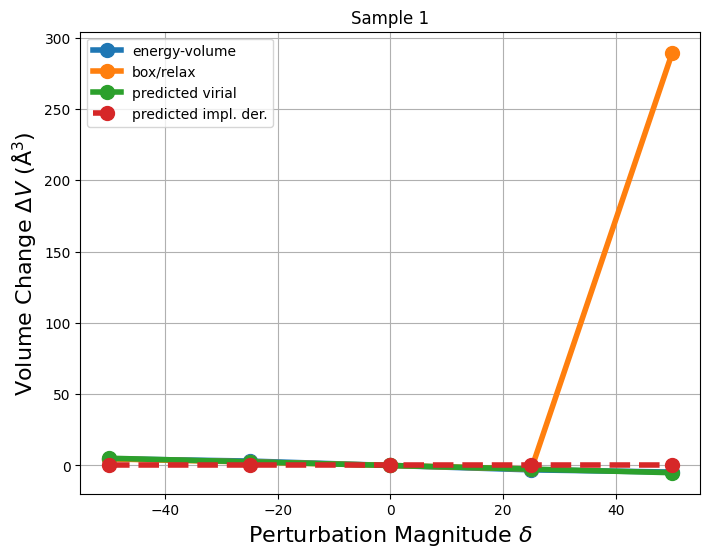

In [22]:
tloc = result['tloc']
print(tloc)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(delta_array, dV_en_vol_array, label='energy-volume', lw=4.0, marker='o', ms=10)
ax.plot(delta_array, dV_box_rel_array, label='box/relax', lw=4.0, marker='o', ms=10)
ax.plot(delta_array, dV_pred_array, label='predicted virial', lw=4.0, marker='o', ms=10)
ax.plot(delta_array, dV_impl_der_array, label='predicted impl. der.', lw=4.0, marker='o', ms=10, ls='--')

ax.set_title(f'Sample {sample}')
fsize=16
ax.set_xlabel('Perturbation Magnitude $\delta$', fontsize=fsize)
ax.set_ylabel('Volume Change $\Delta V$ ($\mathrm{\AA}^3$)', fontsize=fsize)
ax.legend()
ax.grid()
plt.show()

In [23]:
sample_list = [1, 10, 50, 80]

dV_dict = {}

delta_array = np.linspace(-100.0, 100.0, 21)

W_system_tmp = LammpsSim(ncell_x=ncell_x, alat=alat, logname='W_tmp.log', minimize=False, verbose=False)
virial_der0, spline_list, energy_array, volume_array = compute_virial_derivative(W_system_tmp, epsilon_array)

for sample in sample_list:
    print(f'Sample {sample}')
    dV_en_vol_array = np.zeros_like(delta_array)
    dV_box_rel_array = np.zeros_like(delta_array)
    dV_pred_array = np.zeros_like(delta_array)

    dV_dict[sample] = {}

    for i, delta in enumerate(delta_array):
        print(f'{i+1}/{len(delta_array)}')
        result = predict_volume_change(delta, virial_der0, sample=sample, alat0=alat, verbose=False)

        # "Assemble" the dV's into numpy array
        dV_en_vol_array[i] = result['delta_V_en_vol']
        dV_box_rel_array[i] = result['delta_V_box_rel']
        dV_pred_array[i] = result['delta_V_pred']

        # Save the energy-volume data directly into dV_dict
        # make the float of delta as key, hashable
        dV_dict[sample][f'delta_{delta:06.2f}'] = {
            'energy_array': result['energy_array'],
            'pressure_array': result['pressure_array']
        }

    dV_dict[sample]['en_vol'] = dV_en_vol_array
    dV_dict[sample]['box_rel'] = dV_box_rel_array
    dV_dict[sample]['pred'] = dV_pred_array

Sample 1
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
Sample 10
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
Sample 50
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21
Sample 80
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
21/21


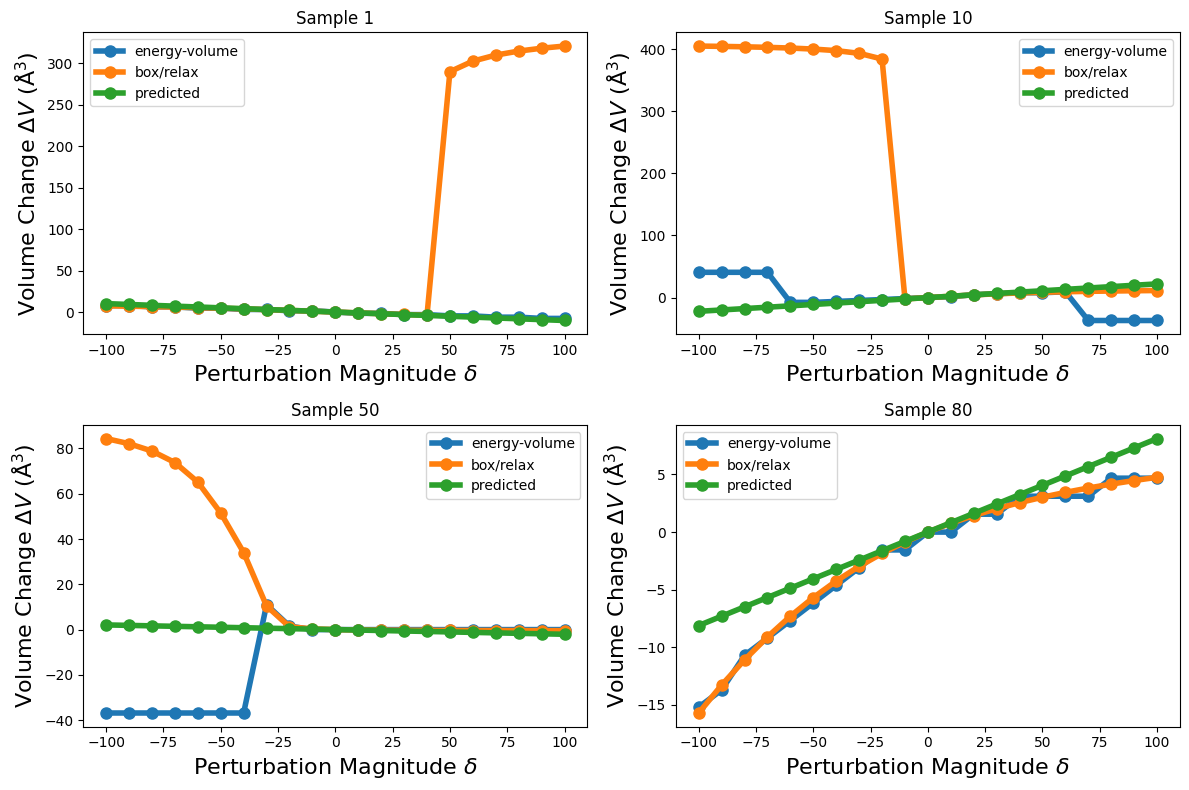

In [24]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ms=8
for i, sample in enumerate(sample_list):
    i_ax, j_ax = i//2, i%2
    axes[i_ax, j_ax].plot(delta_array, dV_dict[sample]['en_vol'], label='energy-volume', lw=4.0, marker='o', ms=ms)
    axes[i_ax, j_ax].plot(delta_array, dV_dict[sample]['box_rel'], label='box/relax', lw=4.0, marker='o', ms=ms)
    axes[i_ax, j_ax].plot(delta_array, dV_dict[sample]['pred'], label='predicted', lw=4.0, marker='o', ms=ms)

    axes[i_ax, j_ax].set_title(f'Sample {sample}')
    fsize=16
    axes[i_ax, j_ax].set_xlabel('Perturbation Magnitude $\delta$', fontsize=fsize)
    axes[i_ax, j_ax].set_ylabel('Volume Change $\Delta V$ ($\mathrm{\AA}^3$)', fontsize=fsize)
    axes[i_ax, j_ax].legend()

plt.tight_layout()
plt.show()


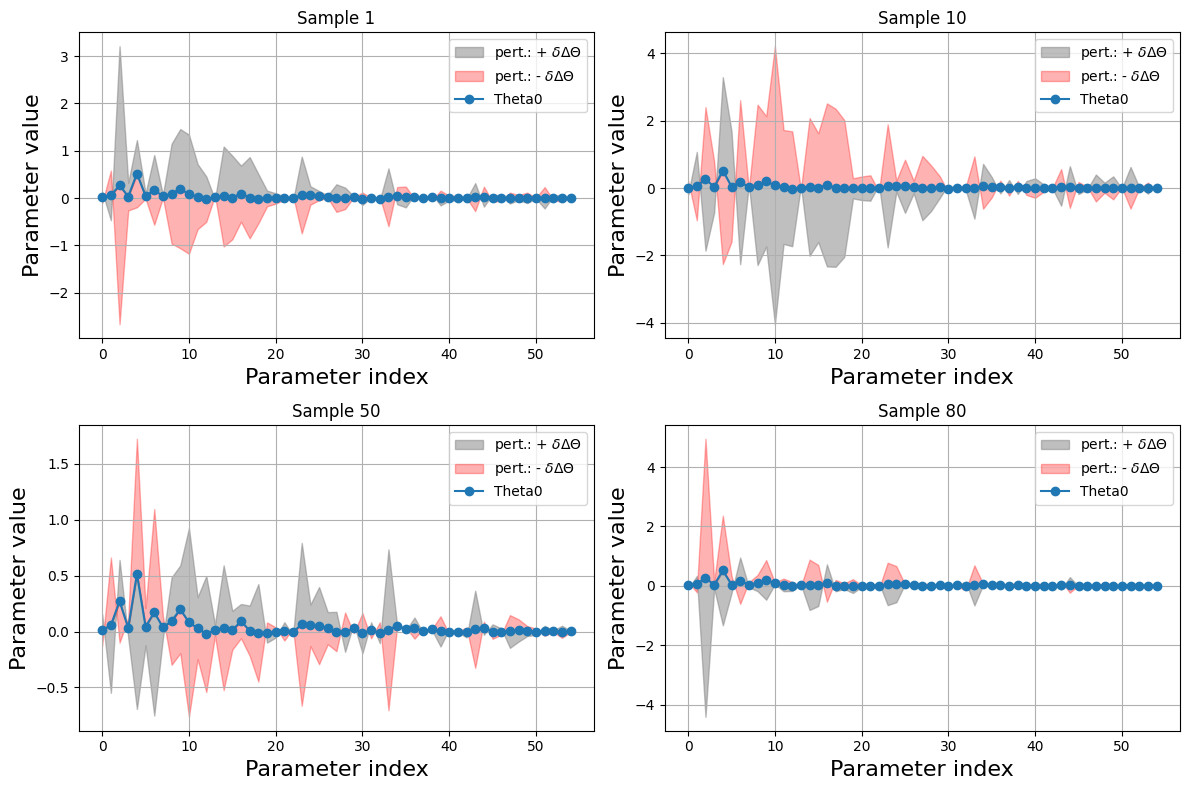

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

s0 = LammpsSim(ncell_x=ncell_x, alat=alat, logname='W_tmp.log', minimize=False, verbose=False)
Theta0 = s0.Theta.copy()
delta = 100.0
alat0 = 3.18427
for i, sample in enumerate(sample_list):
    i_ax, j_ax = i//2, i%2

    s1 = create_perturbed_system(delta=delta, alat=alat0, logname='W_tmp1.log', perturb_type='ens', sample=sample, fix_box_relax=False)
    Theta1 = s1.Theta.copy()

    dTheta = Theta1 - Theta0

    # Fill between T0 + T1 and T0
    axes[i_ax, j_ax].fill_between(np.arange(len(Theta0)), Theta0 + dTheta, Theta0, alpha=0.5, label='pert.: + $\delta \Delta \Theta$', color='gray')
    axes[i_ax, j_ax].fill_between(np.arange(len(Theta0)), Theta0 - dTheta, Theta0, alpha=0.3, label='pert.: - $\delta \Delta \Theta$', color='red')
    axes[i_ax, j_ax].plot(Theta0, marker='o', label='Theta0', color='tab:blue')

    axes[i_ax, j_ax].set_title(f'Sample {sample}')

    fsize=16
    axes[i_ax, j_ax].set_xlabel('Parameter index', fontsize=fsize)
    axes[i_ax, j_ax].set_ylabel('Parameter value', fontsize=fsize)
    axes[i_ax, j_ax].legend()
    axes[i_ax, j_ax].grid()

plt.tight_layout()
plt.show()

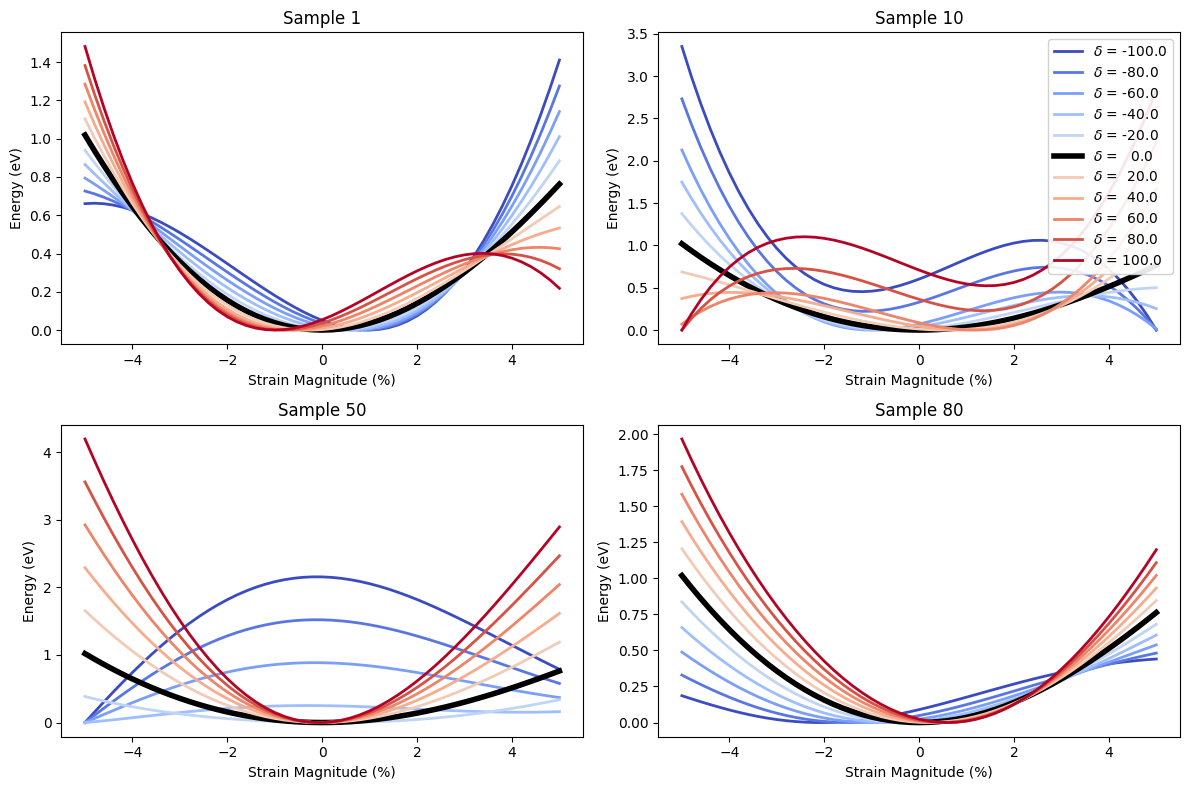

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ndelta = 2
for i, sample in enumerate(sample_list):
    i_ax, j_ax = i//2, i%2

    # color from blue to red as a function of delta
    color_array = np.linspace(0.0, 1.0, len(delta_array[::ndelta]))
    cmap = plt.get_cmap('coolwarm')

    for j, delta in enumerate(delta_array[::ndelta]):
        energy_array = dV_dict[sample][f'delta_{delta:06.2f}']['energy_array']
        pressure_array = dV_dict[sample][f'delta_{delta:06.2f}']['pressure_array']

        if abs(delta) < 0.1:
            color = 'black'
            lw = 4.0
        else:
            color = cmap(color_array[j])
            lw = 2.0

        axes[i_ax, j_ax].plot(100.0 * epsilon_array_pert, energy_array, ls='-', label=f'$\delta$ = {delta:5.1f}', c=color, lw=lw)

    axes[i_ax, j_ax].set_title(f'Sample {sample}')
    axes[i_ax, j_ax].set_xlabel('Strain Magnitude (%)')
    axes[i_ax, j_ax].set_ylabel('Energy (eV)')

# not transparent legend
axes[0, 1].legend(loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()

# Predict the volume change with the implicit derivative

In [27]:
# Implicit derivative of a system WITHOUT fix box/relax
#dX_dTheta = W_perturb.implicit_derivative(method='energy')

In [28]:
sample=1
delta=50.0
W_perturb_fix = create_perturbed_system(delta=delta, sample=sample, alat=alat, fix_box_relax=True, logname='W_perturb_fix.log')

In [29]:
# Implicit derivative of a system WITH fix box/relax
dX_dTheta_fix = W_perturb_fix.implicit_derivative(method='energy', alpha=1e-4, min_style='cg')

In [30]:
print(dX_dTheta_fix)
print(np.max(np.abs(dX_dTheta_fix)))

[[ 4.34434532e-11  4.33575459e-11  4.31988285e-11 ... -1.98404453e-11
  -1.99102437e-11 -2.00937664e-11]
 [-1.08468422e-12 -1.07743778e-12 -1.06022267e-12 ... -7.53003612e-12
  -7.52285401e-12 -7.50525255e-12]
 [-7.67030141e-14 -8.94266508e-14 -1.09807219e-13 ... -6.43873404e-13
  -6.56533904e-13 -6.76908881e-13]
 ...
 [-4.58977209e-12 -2.22216511e-12 -2.93844883e-12 ... -2.70796235e-11
  -2.47113175e-11 -2.54287460e-11]
 [-8.00447808e-12 -8.05134666e-12 -7.92238923e-12 ... -5.62286090e-11
  -5.62780239e-11 -5.61501934e-11]
 [ 5.20277076e-14 -9.88846017e-12  7.62341607e-12 ... -6.68126513e-11
  -7.67527454e-11 -5.92383543e-11]]
3.3626457363142316e-10


In [31]:
volume_init = np.linalg.det(W_system.cell)
alat_init = volume_init**(1/3.0) / ncell_x
print(f'{volume_init=:.3f}, {alat_init=:.5f}')

volume_init=258.297, alat_init=3.18427


In [32]:
coord_init = W_system.X_coord.copy()
Theta0 = W_system.Theta.copy()
Theta1 = W_perturb_fix.Theta.copy()
dTheta = Theta1 - Theta0

dX_pred = dTheta @ dX_dTheta_fix
coord_final = W_system.minimum_image(coord_init + dX_pred)

W_perturb_fix.X_coord = coord_final
W_perturb_fix.scatter_coord()


In [33]:
W_perturb_fix.get_cell()
volume_final = np.linalg.det(W_perturb_fix.cell)
alat_final = volume_final**(1/3.0) / ncell_x

print('Prediction using the implicit derivative')
print(f'{volume_final=:.3f}, {alat_final=:.5f}')

Prediction using the implicit derivative
volume_final=253.662, alat_final=3.16511
